## 0. Imports

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.cm as cm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    balanced_accuracy_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    confusion_matrix
)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.utils import resample
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,5)

In [3]:
sklearn.__version__

'1.1.1'

## 1. Відкрити та зчитати наданий файл з даними.

In [4]:
df = pd.read_csv(r"data/WQ-R.csv",sep=";")

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# 2. Визначити та вивести кількість записів.

In [6]:
print(f"Кількість колонок - {df.shape[0]}\nКільість стовпців - {df.shape[1]}")

Кількість колонок - 1599
Кільість стовпців - 12


# 3. Видалити атрибут quality.

There are 3 big clusters based on quality's values (4,5,6) and others (3,4,8) values are relatively poor presented

In [8]:
# Split data
y = df["quality"].astype(int)
X = df.drop(["quality"], axis = 1)

In [39]:
(y.value_counts().sort_index()/y.shape[0]*100).round(2)

3     0.63
4     3.31
5    42.59
6    39.90
7    12.45
8     1.13
Name: quality, dtype: float64

# 4. Вивести атрибути, що залишилися.

In [9]:
labels = X.columns
print(f"Залишилось {X.shape[1]} стовпців(атрибутів).\nАтрибути які лишились:\n{X.columns.to_list()}")

Залишилось 11 стовпців(атрибутів).
Атрибути які лишились:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [10]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [11]:
# 1. KMeans (optimum n_clusters)
# 2. scatterplot (color for each cluster) per each pair of attributes

## 5. Using the KMeans function of the scikit-learn library, perform:
dividing the data set into clusters with a random initialization and outputting the coordinates of the centers of the clusters.
The optimal number of clusters can be determined based on the initial data set in three different ways:
    1) elbow method;
    2) average silhouette method;
    3) prediction strength method (see section 9.2.3 Determining the Number of Clusters of the book Andriy Burkov. The Hundred-Page Machine Learning Book).
Compare the obtained results and explain which method gave the best result and why (in your opinion).

I have found [this article](https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891) extremely useful.
The article stands out with its easy readability and its effective simplification of complex ideas using relevant examples.
Its clear descriptions and the inclusion of useful functions for cluster analysis make it a highly valuable resource
<img src="img/Silhouette Method.png">

Here is [another article](https://uc-r.github.io/kmeans_clustering), which is great source for studying theory enough to get intuition behind K-means cluster analysis.
Especially, Determining Optimal Clusters topic is written good.

## 5.1) Elbow method

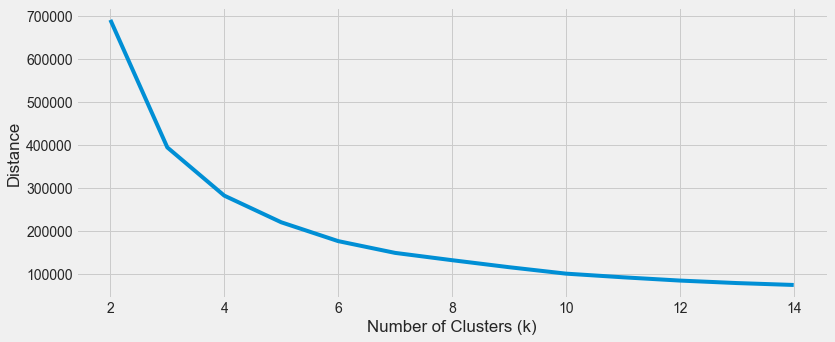

In [31]:
avg_distance = []
range_n_clusters = range(2, 15)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    avg_distance.append(clusterer.inertia_)

style.use("fivethirtyeight")
plt.plot(range_n_clusters, avg_distance)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.show()

In the above plot, there is a sharp fall of average distance at k=3, 4 and 5. Here comes a confusion to pick the best value of k.

## 5.2) Average silhouette method

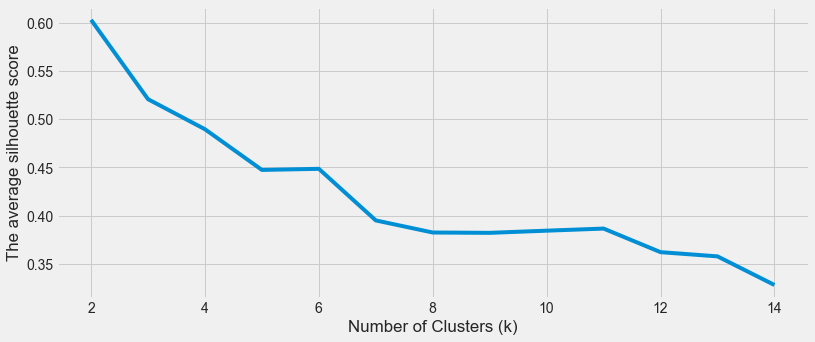

In [32]:
silhouette_avg_n_clusters = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    # print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)

plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("The average silhouette score")
plt.show()

The silhouette plot shows that the n_cluster value of more than 5 is a bad pick,
as the average silhouette score is the same or lower than at n_cluster = 5.
So, let`s investigate deeper n_cluster values 2-5 by plotting the silhouette scores for each sample in cluster.

For n_clusters = 2 The average silhouette_score is : 0.6034220347331241
For n_clusters = 3 The average silhouette_score is : 0.5209776312111326
For n_clusters = 4 The average silhouette_score is : 0.48971967046233833
For n_clusters = 5 The average silhouette_score is : 0.4474368189327113
For n_clusters = 6 The average silhouette_score is : 0.4485800365570335


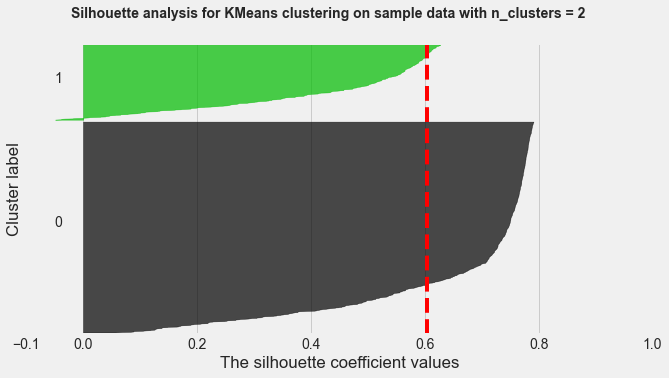

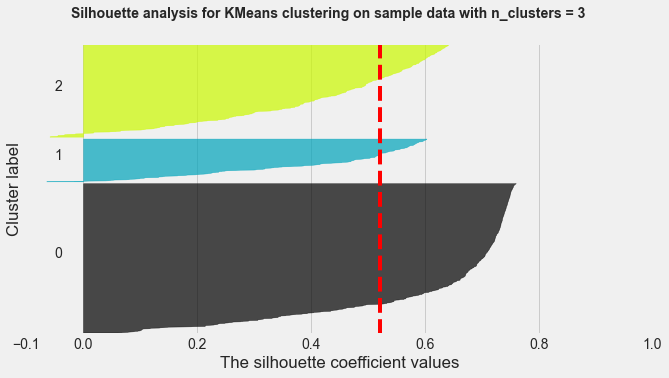

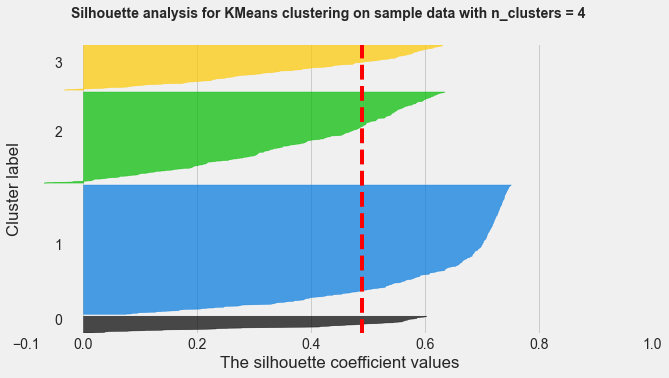

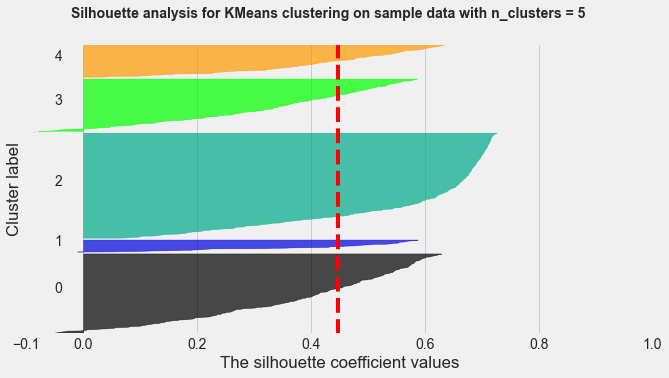

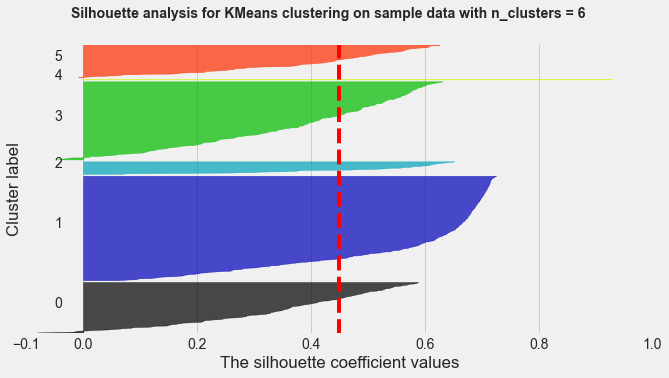

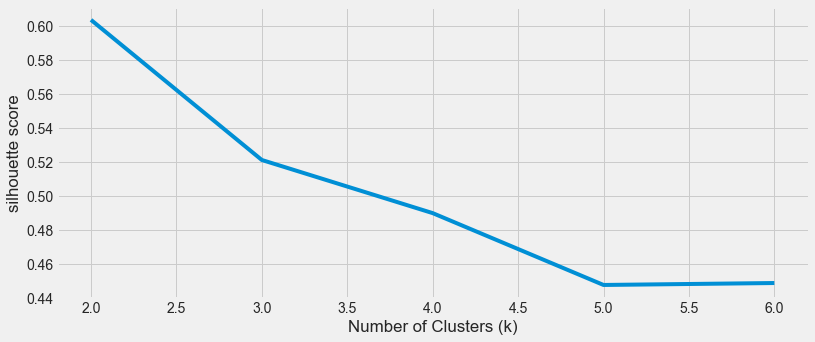

In [33]:
silhouette_avg_n_clusters = []
range_n_clusters = range(2, 7)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 column
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(10, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

The silhouette plots show that all the points in the clusters are below-average silhouette scores.
I prefer to choose between 3 and 4, considering the points in the cluster with cluster_label=1,2 are both higher than 0.6.
Talking in machine learning terms, n_clusters=2 is under-fitting and n_clusters=5 is over-fitting.

## 5.3) Prediction strength method

I have found [this article](https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891) extremely useful.
Especially, Prediction Strength topic with provided python f-ns for calculation.
<img src="img/Prediction Strength.png">

In [50]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [51]:
from prediction_strength import get_closest_centroid, get_prediction_strength

In [53]:
from tqdm.notebook import tqdm

In [ ]:
# running the clustering
strengths = []
range_n_clusters = range(2, 10)

for k in tqdm(range_n_clusters):
    model_train = KMeans(n_clusters=k, random_state=42).fit(X_train)
    model_test = KMeans(n_clusters=k, random_state=42).fit(X_test)

    pred_str = get_prediction_strength(k, model_train.cluster_centers_, X_test, model_test.labels_)
    strengths.append(pred_str)

# plotting
_, ax = plt.subplots()
ax.plot(range_n_clusters, strengths, '-o', color='black')
ax.axhline(y=0.8, c='red')
ax.set(title='Determining the optimal number of clusters',
       xlabel='number of clusters',
       ylabel='prediction strength')

  0%|          | 0/8 [00:00<?, ?it/s]